### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')


In [2]:
wdir = '/automnt/data80/mattho/cmass-ili'

### Load training and test data

In [3]:
def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_halo_Pk(source_path):
    diag_file = join(source_path, 'diag', 'halos.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    return k, Pk, cosmo

In [4]:
# Training suite
suite = 'inf_3gpch'
sim = 'borgpm'
L, N = 3000, 384

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktrain, Pktrain, cosmotrain = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktrain.append(k)
    Pktrain.append(Pk)
    cosmotrain.append(cosmo)

ktrain, Pktrain, cosmotrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain])
ktrain, Pktrain, cosmotrain = map(np.stack, [ktrain, Pktrain, cosmotrain])

100%|██████████| 2000/2000 [01:12<00:00, 27.77it/s]


In [5]:
# Test suite
suite = 'mtng'
sim = 'nbody'
L, N = 3000, 384

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktest, Pktest, cosmotest = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, '0'))
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)

ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])

100%|██████████| 1/1 [00:00<00:00, 27.79it/s]


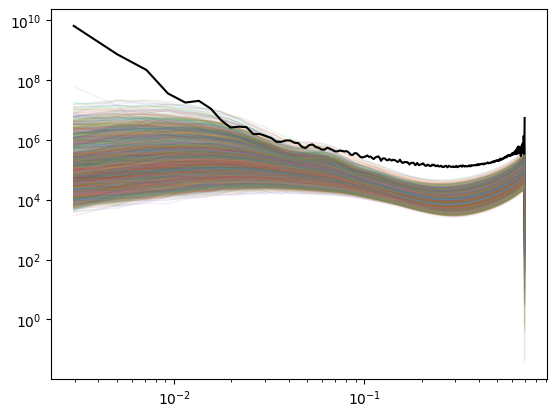

In [12]:
f, ax = plt.subplots()
for k, Pk in zip(ktrain, Pktrain[...,0]):
    ax.loglog(k, Pk, lw=1, alpha=0.1)
ax.loglog(ktest[0], Pktest[0,...,0], 'k')

### Train

In [6]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cuda'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-4
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# train at different resolutions
kmaxs = [0.1, 0.2, 0.4]

# impute with mean
def impute(arr):
    # Compute the mean of each column, ignoring nan values
    col_mean = np.nanmean(arr, axis=0)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[1])
    return arr

In [8]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = cosmotrain

    # log
    x = np.log10(x)

    # impute
    x = impute(x)

    # train
    _p, _s = run_inference(x, theta)
    posteriors[kmax] = _p
    summaries[kmax] = _s


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.1


0 epochs [00:00, ? epochs/s]

467 epochs [05:03,  1.54 epochs/s, loss=-15.3, loss_val=-14.3]
INFO:root:It took 303.5814666748047 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.2


466 epochs [05:05,  1.52 epochs/s, loss=-16.2, loss_val=-14.8]
INFO:root:It took 305.61864018440247 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.4


176 epochs [02:25,  1.21 epochs/s, loss=-14.5, loss_val=-14.4]


KeyboardInterrupt: 

### Plot

In [16]:
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
xobs = impute(xobs)
xobs = x[0]
thetaobs = cosmotest

In [22]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = None
for i, kmax in enumerate(kmaxs[:1]):
    xobs = Pktrain[:, :, 0]
    mask = ktest[0] < kmax
    xobs = xobs[:, mask]
    xobs = np.log10(xobs)
    xobs = impute(xobs)
    _p = posteriors[kmax]
    fig = metric(
        posterior=_p,
        x_obs = xobs[0], theta_fid = thetaobs[0],
        grid=fig,
        name=f'kmax={kmax}'
    )

INFO:root:Sampling models with tensor([1000.]) samples each.













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































3.10/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 742, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 802, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/message.pyx", line 187, in zmq.backend.cython.message.Frame.__cinit__
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/zmq/utils/garbage.py", line 199, in store
    self.start()
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/zmq/utils/garbage.py", line 172, in start
    self.thread.start()
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/threading.py", line 935, in start
    _start_new_thread(self._bootstrap, ())
RuntimeError: can't start new thread
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/data80/mattho/anaconda3/envs/cmass/lib/pytho

In [12]:
xobs.shape

(1, 190)